In [1]:
import numpy as np
from scipy.optimize import curve_fit

import uproot

import seaborn as sns
import matplotlib.pyplot as plt

import zfit
import zfit.z.numpy  
from zfit import z 

#Two muon IDs >0.6
#gamme_E_cms>0.2 GeV
#gamma within CDC acceptance
#ap_theta > 0.175 rad and <2.9 rad
# chi2 > 0


#MC15-mumu:
#/pnfs/desy.de/belle/local/belle/MC/release-06-01-08/DB00002649/MC15rd_b/prod00027831/s00/e0026/4S/r01968/mumu/mdst/sub00/mdst_000001_prod00027831_task251967000001.root


/home/sahil/anaconda3/lib/python3.10/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
signame = ['Signal_8GeV.root']

datsig = [uproot.open(x) for x in signame]

filesig = [x['mumu'].arrays(library='np') for x in datsig]

mcname = ['Output_MC15_V2_mumu.root']

datmc = [uproot.open(x) for x in mcname]

filemc = [x['mumu'].arrays(library='np') for x in datmc]

file = filemc + filesig

/tmp/ipykernel_6796/3141306214.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


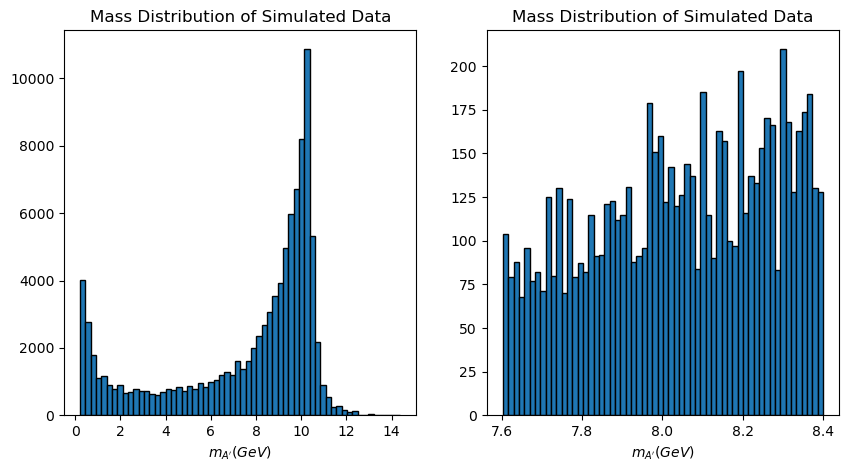

In [3]:
sig = []

initbkg = []
bkg = []

initdat = []
dat = []

randpar = 0.997
bins_ = 60

mean = np.mean(file[1]['ap_InvM'])
std = np.std(file[1]['ap_InvM'])
range_ = (0.95*mean, 1.05*mean)

for i in range(0,100000):
    randgen = np.random.random()
    if randgen>randpar:
        choice = np.random.randint(0,len(file[1]['__experiment__']))
        initdat.append(file[1]['ap_InvM'][choice])
        if file[1]['ap_InvM'][choice]>range_[0] and file[1]['ap_InvM'][choice]<range_[1]:
            dat.append(file[1]['ap_InvM'][choice])
            sig.append(file[1]['ap_InvM'][choice])
    else:
        choice = np.random.randint(0,len(file[0]['__experiment__']))
        initdat.append(file[0]['ap_InvM'][choice])
        initbkg.append(file[0]['ap_InvM'][choice])
        if file[0]['ap_InvM'][choice]>range_[0] and file[0]['ap_InvM'][choice]<range_[1]:
            dat.append(file[0]['ap_InvM'][choice])
            bkg.append(file[0]['ap_InvM'][choice])

fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].hist(initdat, bins = bins_, edgecolor = 'k')
ax[0].set_title('Mass Distribution of Simulated Data')
ax[0].set_xlabel(r"$m_{A'}(GeV)$")

ax[1].hist(dat, bins = bins_, edgecolor = 'k')
ax[1].set_title('Mass Distribution of Simulated Data')
ax[1].set_xlabel(r"$m_{A'}(GeV)$")

fig.show()

/tmp/ipykernel_6796/1661313073.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


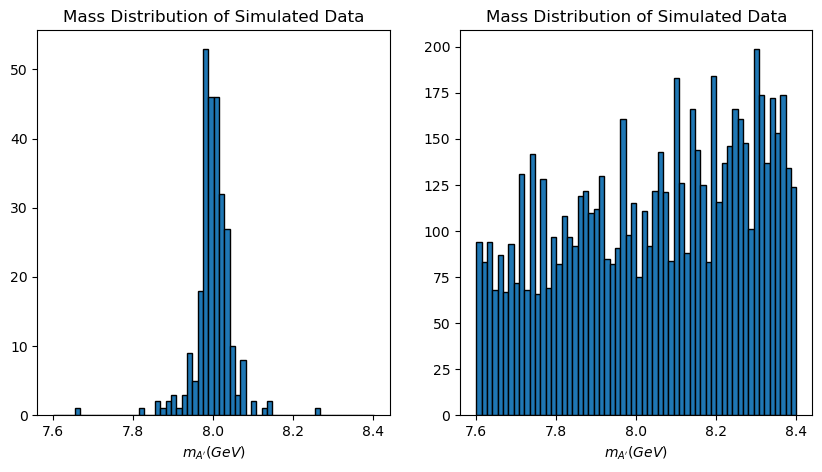

In [4]:
sigdot, sigbin = np.histogram(sig, range = range_, bins = bins_)
sigdot = sigdot/sigdot.sum()
sigcenter = sigbin[:-1] + np.diff(sigbin)/2

bkgdot, bkgbin = np.histogram(bkg, range = range_, bins = bins_)
bkgdot = bkgdot/bkgdot.sum()
bkgcenter = bkgbin[:-1] + np.diff(bkgbin)/2

fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].hist(sig, range = range_, bins = bins_, edgecolor='k')
ax[0].set_title('Mass Distribution of Simulated Data')
ax[0].set_xlabel(r"$m_{A'}(GeV)$")

ax[1].hist(bkg, range = range_, bins = bins_, edgecolor = 'k')
ax[1].set_title('Mass Distribution of Simulated Data')
ax[1].set_xlabel(r"$m_{A'}(GeV)$")

fig.show()

<bound method Figure.show of <Figure size 500x500 with 1 Axes>>

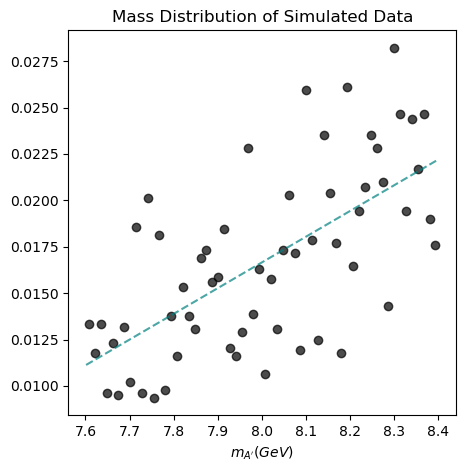

In [5]:
def func(x, a, b):
    return a*x + b

popt, pcov = curve_fit(func, bkgcenter, bkgdot)

xfit = np.linspace(range_[0], range_[1], 200)
yfit = func(xfit, popt[0], popt[1])

fig, ax = plt.subplots(1,1, figsize = (5,5))

ax.plot(bkgcenter, bkgdot, 'o', color = 'k', alpha = 0.7)
ax.plot(xfit, yfit, '--', color = 'teal', alpha = 0.7)
ax.set_title('Mass Distribution of Simulated Data')
ax.set_xlabel(r"$m_{A'}(GeV)$")

fig.show

/tmp/ipykernel_6796/695480508.py:8: RuntimeWarning: invalid value encountered in sqrt
  j1 = (-popt[1]+np.sqrt(k))/popt[0]
/tmp/ipykernel_6796/695480508.py:9: RuntimeWarning: invalid value encountered in sqrt
  j2 = (-popt[1]-np.sqrt(k))/popt[0]


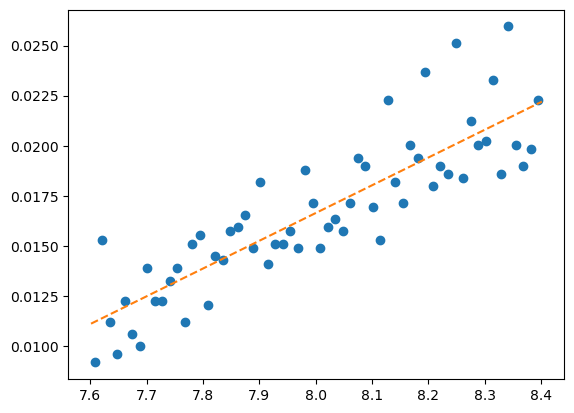

In [6]:
randbkg = []

genrange = (0.55*(popt[0]/2*mean**2 + popt[1]*mean), 1.45*(popt[0]/2*mean**2 + popt[1]*mean))

for i in range(0,100000):
    y = np.random.uniform(genrange[0],genrange[1])
    k = popt[1]**2 + 2*y*popt[0]
    j1 = (-popt[1]+np.sqrt(k))/popt[0]
    j2 = (-popt[1]-np.sqrt(k))/popt[0]
    if j1>range_[0] and j1<range_[1]:
        randbkg.append(j1)
    if j2>range_[0] and j2<range_[1]:
        randbkg.append(j2)
        
n, bins = np.histogram(randbkg, range = range_, bins = bins_)
n = n/n.sum()
binc = bins[:-1] + np.diff(bins)/2

plt.plot(binc,n,'o')
plt.plot(xfit, yfit, '--')
plt.show()

bkgselect = randbkg[0:len(bkg)]

/tmp/ipykernel_6796/957305476.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


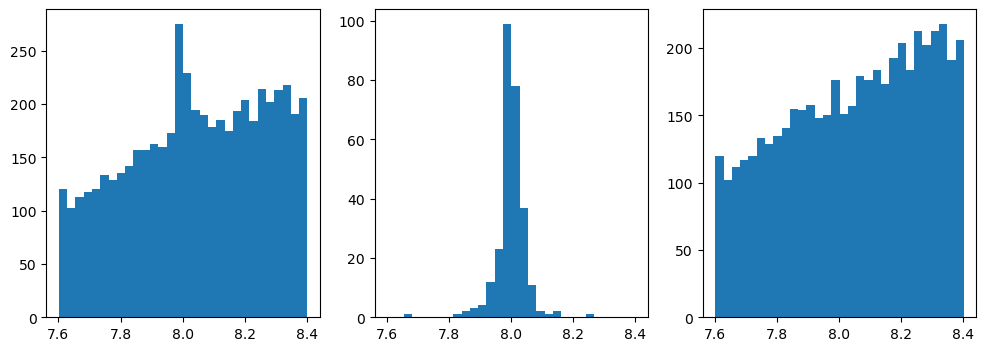

In [7]:
simdata = sig + bkgselect

fig, ax = plt.subplots(1,3, figsize = (12,4))

ax[0].hist(simdata, bins = 30, range = range_)
ax[1].hist(sig, range = range_, bins = 30)
ax[2].hist(bkgselect, range = range_, bins = 30)

fig.show()

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.physics.DoubleCB'>  params=[alphal, alphar, mu, nl, nr, sigma]] data=[<zfit.core.data.Data object at 0x7f859ec02e90>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.2e-05 │ 10000       │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
mu                 8.00071       False
sigma            0.0248341       False
alphal             1.47564       False
nl                 2.70664       False
alphar             1.34304       False
nr                 4.21313       False


Text(0.5, 1.0, "Fitted Signal for $m_{A'} = 8 \\; GeV$")

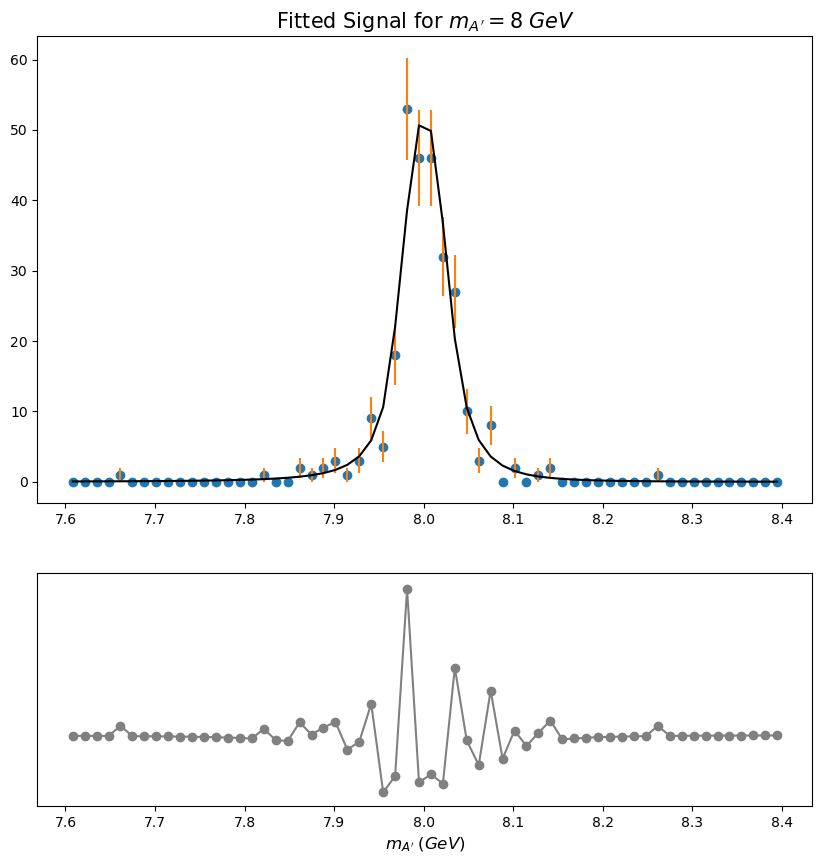

In [14]:
y = np.array(sig)

# mu = zfit.Parameter("mu", np.mean(y))
# sigma = zfit.Parameter("sigma", np.std(y))
# alphal = zfit.Parameter("alphal", 1)
# nl = zfit.Parameter("nl", 1) 
# alphar = zfit.Parameter("alphar", 1)
# nr = zfit.Parameter("nr", 1) 

obs = zfit.Space('x', limits=range_)
data = zfit.data.Data.from_numpy(obs=obs, array=y)

dcb = zfit.pdf.DoubleCB(obs=obs, mu=mu, sigma=sigma, alphal = alphal, nl = nl, alphar = alphar, nr = nr)

nll = zfit.loss.UnbinnedNLL(model=dcb, data=data) 

minimizer = zfit.minimize.Minuit()
minimum = minimizer.minimize(loss=nll)

params = minimum.params

print(minimum)
    
j, bins = np.histogram(y, range = range_, bins = bins_)
bins_center = bins[:-1] + np.diff(bins)/2     
err = np.sqrt(j)
                        


pdf = zfit.run(dcb.pdf(bins_center))
    
fitsig = y.shape[0] * (range_[1] - range_[0]) * pdf / bins_

j, bins = np.histogram(y, range = range_, bins = bins_)
bins_center = bins[:-1] + np.diff(bins)/2     
err = np.sqrt(j)

fit = y.shape[0] * (range_[1] - range_[0]) * pdf / bins_
    
diff = j - fit

fig, ax = plt.subplots(2,1, figsize = (10,10), gridspec_kw={'height_ratios': [2, 1]})
                        
ax[1].plot(bins_center, diff, 'o-', color = 'gray')
ax[1].set_xlabel("$m_{A'}\; (GeV)$", fontsize = 12)
ax[1].set_ylim(-7,16)
ax[1].set_yticks([])

ax[0].plot(bins_center, j, 'o')
ax[0].errorbar(bins_center, j, yerr=err, linestyle='')
ax[0].plot(bins_center, fitsig, color = 'black')

ax[0].set_title("Fitted Signal for $m_{A'} = 8 \; GeV$", fontsize = 15)


In [ ]:
y = np.array(bkgselect)

#low = zfit.Parameter("low", range_[0])
#high = zfit.Parameter("high", range_[1])

lam = zfit.Parameter("lam", 1)

obs = zfit.Space('x', limits=range_)
data = zfit.data.Data.from_numpy(obs=obs, array=np.array(bkgselect))

exp = zfit.pdf.Exponential(lam = lam, obs=obs)

nll = zfit.loss.UnbinnedNLL(model=exp, data=data) 

minimizer = zfit.minimize.Minuit()
minimum = minimizer.minimize(loss=nll)

params = minimum.params

print(minimum)
    
j, bins = np.histogram(y, range = range_, bins = bins_)
bins_center = bins[:-1] + np.diff(bins)/2     
err = np.sqrt(j)
                        
plt.plot(bins_center, j, 'o')
plt.errorbar(bins_center, j, yerr=err, linestyle='')

pdf = zfit.run(exp.pdf(bins_center))
    
fitbkg = y.shape[0] * (range_[1] - range_[0]) * pdf / bins_
    
plt.plot(bins_center, fitbkg, color = 'black')
plt.xlabel("GeV", fontsize = 12)
plt.show()

In [ ]:
dat, datbin = np.histogram(simdata, bins = bins_, range = range_)

datbin_center = datbin[:-1] + np.diff(datbin)/2

daterr = np.sqrt(dat)

plt.plot(bins_center, fitbkg, color = 'red', label = 'Background')
plt.plot(bins_center, fitsig, color = 'blue', label = 'Signal')
plt.plot(bins_center, fitsig + fitbkg, color = 'olive', label = 'Combined Fit')
plt.plot(datbin_center, dat, 'o', color = 'black', alpha=0.5)
plt.errorbar(datbin_center, dat, yerr = daterr, linestyle = '', color = 'black', alpha=0.5)
plt.legend()
plt.show()

In [ ]:
dcb_yield = zfit.Parameter('dcb_yield', 1, step_size = 1)
exp_yield = zfit.Parameter('exp_yield', 1, step_size = 1)

dcb.set_yield(dcb_yield)
exp.set_yield(exp_yield)

model = zfit.pdf.SumPDF([exp,dcb])

In [ ]:
mu.floating = False
sigma.floating = False
alphal.floating = False
nl.floating = False
alphar.floating = False
nr.floating = False
lam.floating = False

data = zfit.data.Data.from_numpy(obs=obs, array=np.array(simdata))

nllfinal = zfit.loss.ExtendedUnbinnedNLL(model = model, data = data)

check = minimizer.minimize(nllfinal)
check.error()

print(check)

In [ ]:
from hepstats.hypotests.calculators import AsymptoticCalculator
from hepstats.hypotests.parameters import POI

dcb_yield_poi = POI(dcb_yield, 1)
calculator = AsymptoticCalculator(input=check, minimizer=minimizer)

from hepstats.hypotests import Discovery

discovery = Discovery(calculator=calculator, poinull=dcb_yield_poi)
discovery.result()

In [ ]:
print(len(sig))